## Linear regression model for car price forecasting

Importing all necessary modules

In [952]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor
import category_encoders as ce


import seaborn as sns
sns.set()

Importing dataset. We can observe that there are numeric and categorical columns. So we'll further need to encode categorical ones to use them in our model.

In [953]:
data = pd.read_csv('1.04. Real-life example.csv')
data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [954]:
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


In [955]:
data.dropna(subset=['Price'],axis=0,inplace=True)
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4173,4173.000000,4173,4173.000000,4025.000000,4173,4173,4173.000000,4173
unique,7,NaN,6,NaN,NaN,4,2,NaN,310
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,908,NaN,1604,NaN,NaN,1903,3779,NaN,193
mean,NaN,19418.746935,NaN,164.088426,2.764586,NaN,NaN,2006.367362,NaN
std,NaN,25584.242620,NaN,104.823056,4.935941,NaN,NaN,6.686728,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


G:\Anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
G:\Anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


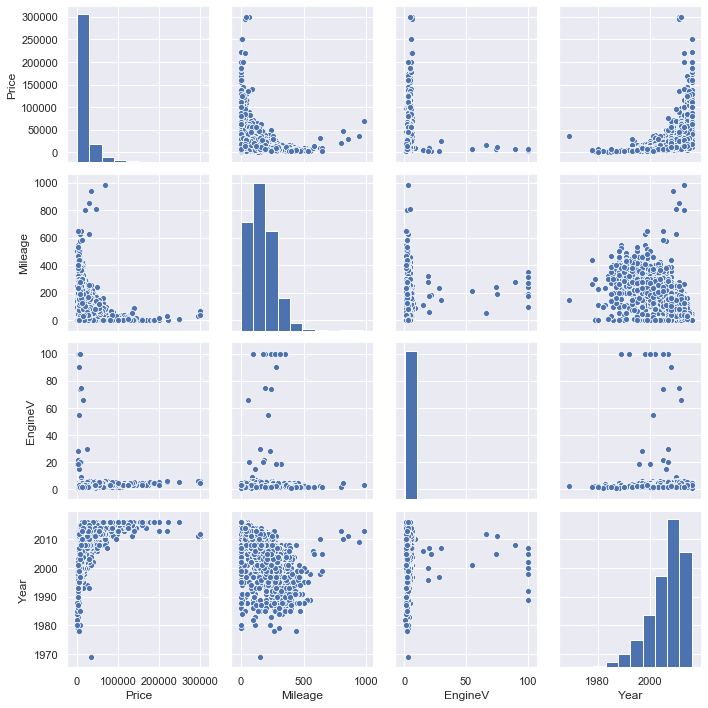

In [956]:
sns.pairplot(data, height=2.5)
plt.tight_layout()

In [957]:
data[['Year','Price']].sort_values(by=['Year']).head()

,Year,Price
810,1969,34999.0
1025,1978,2300.0
4319,1978,5500.0
288,1979,600.0
2122,1979,2990.0


In [958]:
data[['Mileage','Year','Price']].sort_values(by=['Mileage']).tail(10)

,Mileage,Year,Price
3283,580,2005,13000.0
1813,630,1998,8500.0
534,630,2010,30500.0
3222,650,2005,9500.0
3457,650,1999,3200.0
3091,800,2013,20500.0
3625,810,2010,47700.0
1041,850,2011,29500.0
3567,940,2009,36000.0
2607,980,2013,68700.0


In [959]:
data=data[data['EngineV']<6.5]
data=data[data['Year']>1970]
data=data[data['Mileage']<800]
data=data[data['Price']<150000]
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3969,3969.000000,3969,3969.000000,3969.000000,3969,3969,3969.000000,3969
unique,7,NaN,6,NaN,NaN,4,2,NaN,302
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,874,NaN,1518,NaN,NaN,1848,3604,NaN,188
mean,NaN,18221.719063,NaN,163.985135,2.447652,NaN,NaN,2006.338624,NaN
std,NaN,20041.622016,NaN,101.216617,0.949419,NaN,NaN,6.654584,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1978.000000,NaN
25%,NaN,6999.000000,NaN,92.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,159.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21500.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


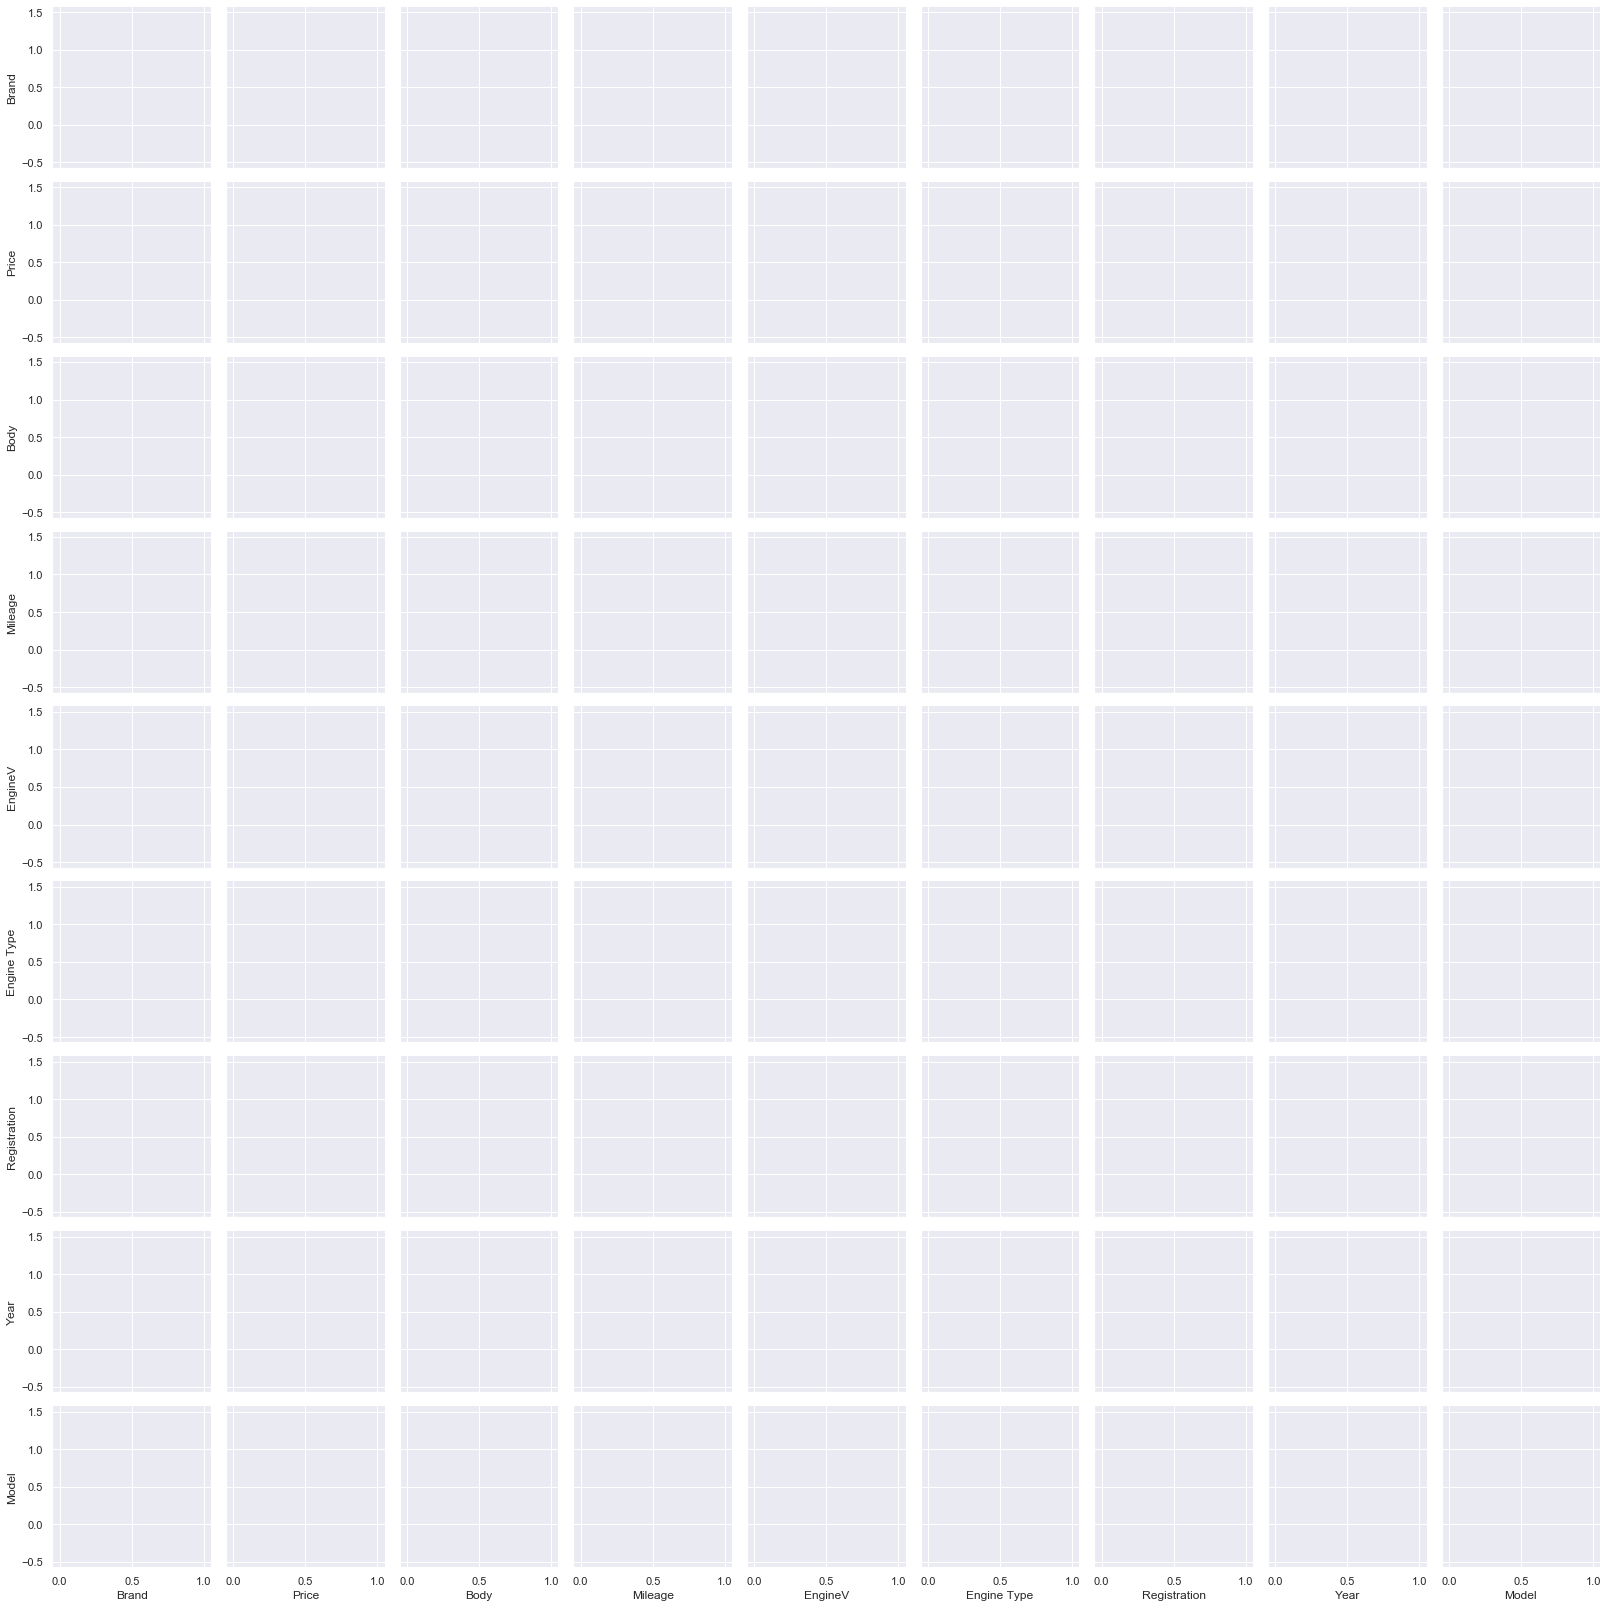

In [960]:
sns.pairplot(data[data['Price']<7.5], height=2.5)
plt.tight_layout()

In [961]:
data['Model_Year']=data['Model']+'_'+data['Year'].astype('str')

model_quantity=data.sort_values(by=['Model','Year']).groupby('Model_Year').count()
model_quantity=model_quantity.iloc[:,1].rename('Model_quantity')

data=data.join(model_quantity, on='Model_Year')
data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Model_Year,Model_quantity
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320,320_1991,2
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212,Sprinter 212_1999,2
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500,S 500_2003,2
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7,Q7_2007,17
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4,Rav 4_2011,6


In [962]:
new_min=data.groupby('Model')[['Year']].min()
new_min=new_min.rename(columns={"Year":"Min_year"})
data=data.join(new_min, on='Model')
data['Oldness']=data['Year']-data['Min_year']
data=data.drop(['Model_Year','Min_year'],axis=1)
data.head()




,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Model_quantity,Oldness
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320,2,5
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212,2,2
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500,2,7
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7,17,1
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4,6,12


In [963]:
# cet=ce.TargetEncoder()
# data['Year']=cet.fit_transform(data['Year'].astype('str'), data['Price'])
# print(data['Year'].head())

In [964]:
variables = data[['Mileage','EngineV','Oldness','Model_quantity','Year']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,3.709381,Mileage
1,7.808489,EngineV
2,2.484490,Oldness
3,2.267944,Model_quantity
4,14.477780,Year


In [965]:
# data.drop('Year',axis=1,inplace=True)
data['Year'].astype('str')
data=data.rename(columns={'Year':'Avg_price_in_year'})

data['Price']= np.log(data['Price'])

In [966]:
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Avg_price_in_year,Model,Model_quantity,Oldness
count,3969,3969.000000,3969,3969.000000,3969.000000,3969,3969,3969.000000,3969,3969.000000,3969.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN,302,NaN,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class,NaN,NaN
freq,874,NaN,1518,NaN,NaN,1848,3604,NaN,188,NaN,NaN
mean,NaN,9.391535,NaN,163.985135,2.447652,NaN,NaN,2006.338624,NaN,6.663391,9.150920
std,NaN,0.904396,NaN,101.216617,0.949419,NaN,NaN,6.654584,NaN,6.240321,8.121504
min,NaN,6.396930,NaN,0.000000,0.600000,NaN,NaN,1978.000000,NaN,1.000000,0.000000
25%,NaN,8.853523,NaN,92.000000,1.800000,NaN,NaN,2003.000000,NaN,2.000000,3.000000
50%,NaN,9.350102,NaN,159.000000,2.200000,NaN,NaN,2007.000000,NaN,5.000000,7.000000
75%,NaN,9.975808,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN,9.000000,14.000000


In [967]:
y=data.Price
X=data.drop('Price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [968]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                        X_train[cname].dtype == "object"]

big_categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() >= 10 and 
                        X_train[cname].dtype == "object"]

print(categorical_cols)
print(big_categorical_cols)

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

print(numerical_cols)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

big_categorical_transformer=ce.TargetEncoder()


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('big_cat',big_categorical_transormer, big_categorical_cols)
    ])

['Brand', 'Body', 'Engine Type', 'Registration']
['Model']
['Mileage', 'EngineV', 'Avg_price_in_year', 'Model_quantity', 'Oldness']


In [969]:
model = LinearRegression()

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_test)

# Evaluate the model
score = mean_absolute_error(np.exp(y_test), np.exp(preds))
R2=r2_score(np.exp(y_test), np.exp(preds))
adj_R2=1-(1-R2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)

predictions=pd.DataFrame(np.exp(preds), columns=['Prediction'])
y_test = y_test.reset_index(drop=True)
predictions['Target']=np.exp(y_test)
predictions['Residuals']=predictions['Target']-predictions['Prediction']
predictions['Difference%'] = np.absolute(predictions['Residuals']/predictions['Target']*100)
MAPE=np.absolute(predictions['Residuals'].sum()/predictions['Target'].sum()*100)



print('R2:',R2.round(decimals=3))
print('adj_R2:',adj_R2.round(decimals=3))
print('MAE:', score.round(decimals=3))
print('MAPE:', MAPE.round(decimals=3))
# print(predictions.sort_values(by=['Difference%']).tail(30))




R2: 0.786
adj_R2: 0.783
MAE: 4296.955
MAPE: 7.297


In [970]:
predictions.describe()

,Prediction,Target,Residuals,Difference%
count,794.000000,794.000000,794.000000,794.000000
mean,17372.921918,18740.420038,1367.498120,23.215899
std,15026.353864,20819.868359,9535.104097,35.721223
min,1075.522186,600.000000,-30483.336744,0.072384
25%,6966.211228,6800.000000,-1735.914785,8.146145
50%,12419.655050,11550.000000,-59.466907,16.579866
75%,22428.640373,22675.000000,1913.790793,28.460016
max,88823.691907,140000.000000,91328.003698,653.583500


Text(0, 0.5, 'Residuals')

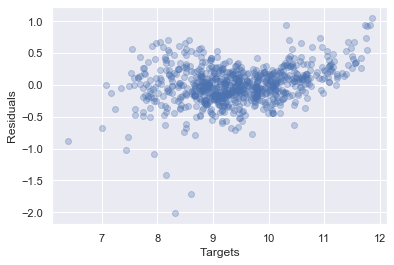

In [971]:
plt.scatter(y_test,y_test-preds,alpha=0.3)
plt.xlabel('Targets',size=12)
plt.ylabel('Residuals',size=12)

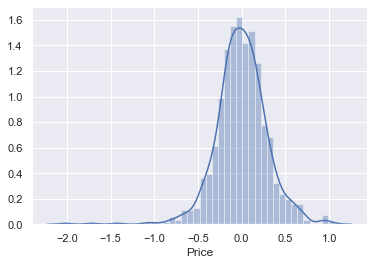

In [972]:
sns.distplot(y_test-preds)

(6.5, 12)

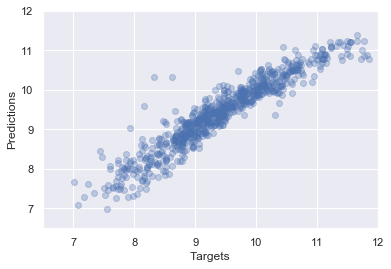

In [973]:

plt.scatter(y_test,preds,alpha=0.3)
plt.xlabel('Targets',size=12)
plt.ylabel('Predictions',size=12)
plt.xlim(6.5,12)
plt.ylim(6.5,12)


In [974]:
scores=cross_val_score(my_pipeline, X, y, cv=5)
print('Accuracy:',scores.mean().round(decimals=3))

Accuracy: 0.896


In [975]:
X_train_OLS=X_train
y_train_OLS=y_train

X_train_OLS[numerical_cols]=numerical_transformer.fit_transform(X_train[numerical_cols])
X_train_OLS[big_categorical_cols]=big_categorical_transformer.fit_transform(X_train[big_categorical_cols],y_train)
X_train_OLS=pd.get_dummies(X_train_OLS, drop_first=True)


X = sm.add_constant(X_train_OLS)
model_2 = sm.OLS(np.array(y_train_OLS),X)
results = model_2.fit()
results.summary()

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
G:\Anaconda\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
G:\Anaconda\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     1392.
Date:                Sun, 09 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:36:54   Log-Likelihood:                -480.72
No. Observations:                3175   AIC:                             1005.
Df Residuals:                    3153   BIC:                             1139.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.3399      0.134     47.473      0.000       6.078       6.602
Mileage                -0.0941      0.007    -12.617      0.000      -0.109      -0.079
EngineV                 0.1595      0.007     23.285      0.000       0.146       0.173
Avg_price_in_year       0.4612      0.009     51.701      0.000       0.444       0.479
Model                   0.2866      0.014     20.945      0.000       0.260       0.313
Model_quantity         -0.0548      0.005    -10.088      0.000      -0.065      -0.044
Oldness                 0.0435      0.007      6.395      0.000       0.030       0.057
Brand_BMW               0.0174      0.021      0.833      0.405      -0.023       0.058
Brand_Mercedes-Benz    -0.0483      0.020     -2.363      0.018      -0.088      -0.008
Brand_Mitsubishi       -0.3784      0.025    -15.032      0.000      -0.428      -0.329
Brand_Renault          -0.5436      0.024    -22.799      0.000      -0.590      -0.497
Brand_Toyota           -0.2576      0.022    -11.467      0.000      -0.302      -0.214
Brand_Volkswagen       -0.2301      0.020    -11.606      0.000      -0.269      -0.191
Body_hatch             -0.2421      0.027     -9.105      0.000      -0.294      -0.190
Body_other             -0.1546      0.022     -6.998      0.000      -0.198      -0.111
Body_sedan             -0.1703      0.018     -9.319      0.000      -0.206      -0.134
Body_vagon             -0.2024      0.024     -8.466      0.000      -0.249      -0.156
Body_van               -0.2785      0.022    -12.747      0.000      -0.321      -0.236
Engine Type_Gas        -0.1130      0.017     -6.521      0.000      -0.147      -0.079
Engine Type_Other      -0.0757      0.032     -2.382      0.017      -0.138      -0.013
Engine Type_Petrol     -0.1155      0.014     -8.430      0.000      -0.142      -0.089
Registration_yes        0.8362      0.019     43.972      0.000       0.799       0.873
==============================================================================
Omnibus:                      230.123   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1076.784
Skew:                          -0.161   Prob(JB):                    1.51e-234
Kurtosis:                       5.835   Cond. No.                         258.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [976]:
variables = X_train_OLS[['Mileage','EngineV','Oldness','Model_quantity','Avg_price_in_year']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,1.878756,Mileage
1,1.019902,EngineV
2,1.131538,Oldness
3,1.091243,Model_quantity
4,2.027083,Avg_price_in_year
